In [1]:
options(warn = -1)
###On télécharge les libraries utiles
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(gglorenz, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(reshape2, warn.conflicts = FALSE)
library(reldist, warn.conflicts = FALSE)
library(rstatix, warn.conflicts = FALSE)
library(car, warn.conflicts = FALSE)
library(lmtest, warn.conflicts = FALSE)
library(olsrr, warn.conflicts = FALSE)
library(nortest, warn.conflicts = FALSE)
library(corrplot, warn.conflicts = FALSE)
select<-dplyr::select

setwd("C:/Users/Bruno/Desktop/ouvrablesFormations/P7_pinos_bruno")

reldist: Relative Distribution Methods
Version 1.6-6 created on 2016-10-07.
copyright (c) 2003, Mark S. Handcock, University of California-Los Angeles
 For citation information, type citation("reldist").
 Type help(package="reldist") to get started.

Loading required package: carData
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

corrplot 0.84 loaded


In [2]:
###Mission 1#########################################################

###On charge le tableau principal du projet de la WID
df<-read.csv("data-projet7.csv")

df$income<-df$income%>%as.vector()%>%sub(",",".",.)%>%
  as.numeric()

df$gdpppp<-df$gdpppp%>%as.vector()%>%sub(",",".",.)%>%
  as.vector()%>%as.numeric()

###Je supprime les pays dont les données sont trop éloignées de 2008
###car mon étude est faite sur cette année là
###Je supprime des pays qui poseront problème plutard
df<-filter(df, year_survey %in% 2006:2010)%>%
  filter(!(country %in% c("FJI", "XKX", "PSE")))

###J'augmente de 3.6% les revenu de 2006 car la croissance du gdpppp
###mondial a été de 3.6% entre 2006 et 2008
df[df$year_survey == 2006,"gdpppp"]<-
  df[df$year_survey == 2006,"gdpppp"]*1.036

df[df$year_survey == 2006,"income"]<-
  df[df$year_survey == 2006,"income"]*1.036

###Je divise par 0.97 les pays étudié en 2009 car le gdpppp mondiale
###a chuté de 3% entre 2008 et 2009
df[df$year_survey == 2009,"gdpppp"]<-
  df[df$year_survey == 2009,"gdpppp"]/0.97

df[df$year_survey == 2009,"income"]<-
  df[df$year_survey == 2009,"income"]/0.97

###Les autres variations sont négligeable je laisse les données 2007 et 
###2011 telles quelles

###Je considère que mes données correspondent à l'année 2008
###après les ajustements
df$year_survey<-2008

###Il manquait un percentile à la lituanie je les ajouté en faisant
###la moyenne du précédant et du suivant
df<-df%>%rbind(df[5940,])   

df[11100,"quantile"]<-41

df[11100,"income"]<-(4868.4507 + 4895.8306)/2

df<-df%>%arrange(country, quantile)

rownames(df)<-1:11100

head(df)

country,year_survey,quantile,nb_quantiles,income,gdpppp
ALB,2008,1,100,728.8980,7297
ALB,2008,2,100,916.6623,7297
ALB,2008,3,100,1010.9160,7297
ALB,2008,4,100,1086.9078,7297
ALB,2008,5,100,1132.6997,7297
ALB,2008,6,100,1171.1412,7297


In [3]:
###Je charge une table pour faire la correspondance entre 
###l'écriture en 3 lettres des pays et le nom complet
country_full<-read.csv("sql-pays.csv", encoding = "UTF-8", header = FALSE)%>%
  select("country" = V4, "country_full" = V5)

country_full$country<-country_full$country%>%as.vector()
country_full$country_full<-country_full$country_full%>%as.vector()

###J'en ajoute deux qui sont présent dans mon étude et pas sur le fichier
country_full[242,]<-c("SRB","Serbie")
country_full[243,]<-c("MNE","Monténégro")

###Je change le nom de la macédoine du nord (trop long)
country_full[country_full$country == "MKD", "country_full"]<-"Macédoine du Nord"

###Je fait une jointure entre mes deux tables pour ajouter la colonne
###nom complet a ma table de base
dfs<-inner_join(country_full,df)

head(dfs)

Joining, by = "country"


country,country_full,year_survey,quantile,nb_quantiles,income,gdpppp
ALB,Albanie,2008,1,100,728.8980,7297
ALB,Albanie,2008,2,100,916.6623,7297
ALB,Albanie,2008,3,100,1010.9160,7297
ALB,Albanie,2008,4,100,1086.9078,7297
ALB,Albanie,2008,5,100,1132.6997,7297
ALB,Albanie,2008,6,100,1171.1412,7297


[1] 11100

In [4]:
###Je charge une table de la FAO avec la pop en 2008 des pays
fao<-read.csv("pop_2008.csv",
              encoding = "UTF-8")%>%
  select("country_full" = "Zone", "pop" = "Valeur")

###Je modifie les country_full qui ne correspondent pas exactement
fao$country_full<-fao$country_full%>%as.vector()

fao$country_full[fao$country_full == "États-Unis d'Amérique"]<-"États-Unis"

fao$country_full[fao$country_full == 
               "Bolivie (État plurinational de)"]<-"Bolivie"

fao$country_full[fao$country_full == "République centrafricaine"]<-
  "République Centrafricaine"

fao$country_full[fao$country_full == "Chine, continentale"]<-"Chine"

fao$country_full[fao$country_full == "Chine, Taiwan Province de"]<-
  "Taïwan"

fao$country_full[fao$country_full == "République démocratique du Congo"]<-
  "République Démocratique du Congo"

fao$country_full[fao$country_full == "Tchéquie"]<-"République Tchèque"

fao$country_full[fao$country_full == "République dominicaine"]<-
  "République Dominicaine"

fao$country_full[fao$country_full == "Iran (République islamique d')"]<-
  "République Islamique d'Iran"

fao$country_full[fao$country_full == "République démocratique populaire lao"]<-
  "République Démocratique Populaire Lao"

fao$country_full[fao$country_full == "Soudan (ex)"]<-"Soudan"

fao$country_full[fao$country_full == "Eswatini"]<-"Swaziland"

fao$country_full[fao$country_full == "République arabe syrienne"]<-
  "République Arabe Syrienne"

fao$country_full[fao$country_full == 
  "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]<-
  "Royaume-Uni"

fao$country_full[fao$country_full == 
               "Venezuela (République bolivarienne du)"]<-"Venezuela"
	

###Je fais une jointure entre ma table principale et la table de la FAO
###pour obtenir ma colonne pop
df<-inner_join(dfs,fao)

head(df)

Joining, by = "country_full"


country,country_full,year_survey,quantile,nb_quantiles,income,gdpppp,pop
ALB,Albanie,2008,1,100,728.8980,7297,3002.678
ALB,Albanie,2008,2,100,916.6623,7297,3002.678
ALB,Albanie,2008,3,100,1010.9160,7297,3002.678
ALB,Albanie,2008,4,100,1086.9078,7297,3002.678
ALB,Albanie,2008,5,100,1132.6997,7297,3002.678
ALB,Albanie,2008,6,100,1171.1412,7297,3002.678


[1] 11100

In [5]:
###Je calcul le nombre de pays analysé dans l'étude
pays_analyse<-nrow(df)/100
cat("le nombre de pays analysé est",pays_analyse,"\n")

###Je calcul la pop analysée dans l'étude
pop_analyse<-sum(df$pop)/100
cat("la population analysé en millier est",pop_analyse)

###Je calcul le pourcentage de pop analysé dans l'étude
prct_pop<-round(pop_analyse*100/7041194.301,1)
cat(" soit",prct_pop,"% de la population mondiale en 2008")

le nombre de pays analysé est 111 
la population analysé en millier est 6202566 soit 88.1 % de la population mondiale en 2008

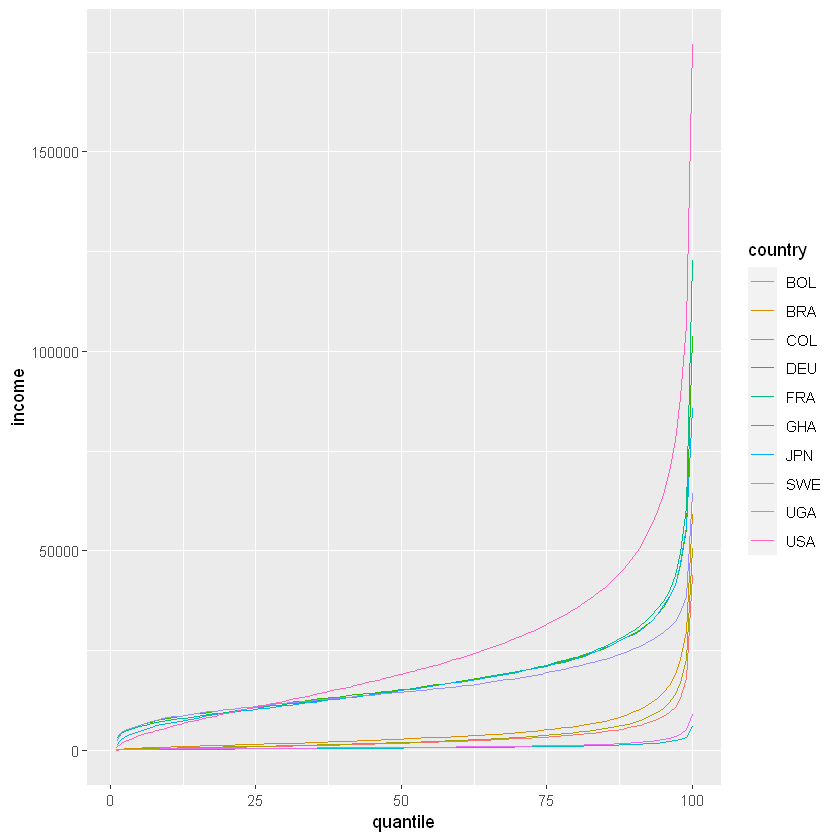

In [6]:
###Mission2##########################################################

###Je cré un vecteur avec les pays qui vont m'intéresser plus
###particulièrement pour la suite
liste_pays<-c("FRA","SWE","BRA","JPN","DEU","USA","GHA","COL","UGA",
              "BOL")
              
###Je cré une table avec seulement ces pays là
dff<-df%>%filter(country %in% 
  liste_pays)

###Je trace la courbe du revenu par rapport à la classe pour mes 10 pays
ggplot(dff,
       aes(x = quantile, y = income))+
  geom_line(aes(colour = country))

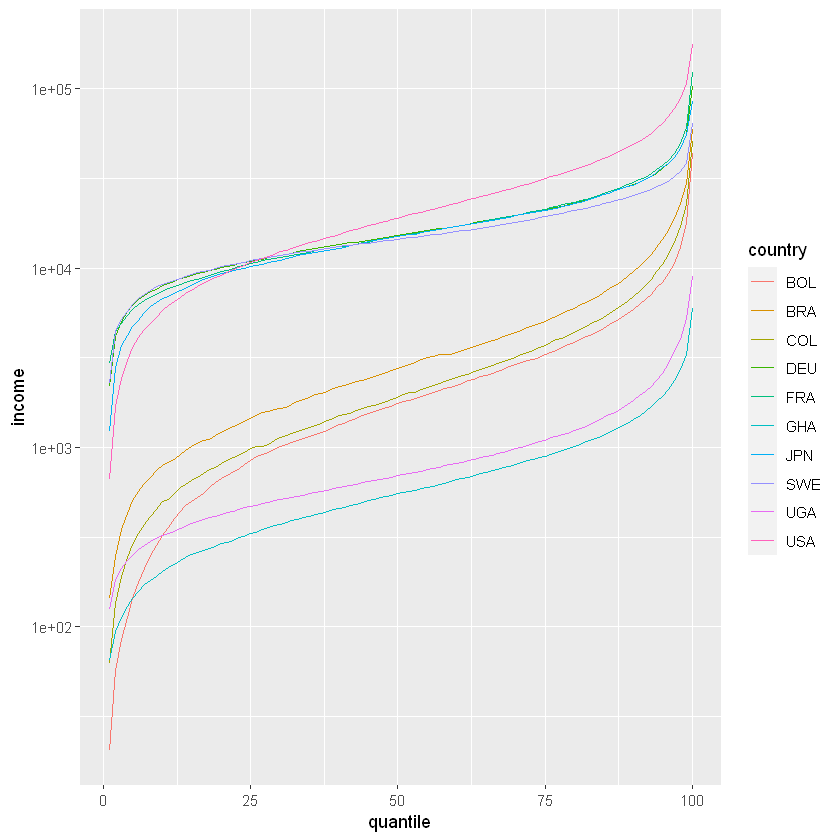

In [7]:
###Je trace la même chose mais avec une échelle log10
ggplot(dff,
       aes(x = quantile, y = income))+
  geom_line(aes(colour = country)) +
  scale_y_continuous(trans='log10')

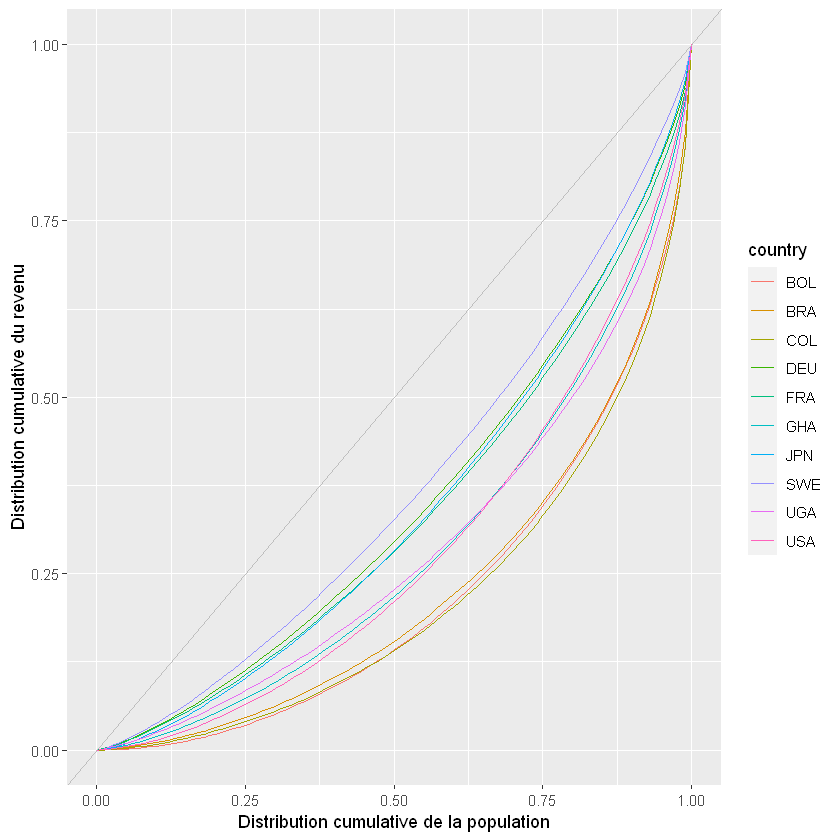

In [8]:
###Je trace les courbe de lorenz de ces pays
ggplot(dff, aes(income)) + 
  stat_lorenz(aes(colour = country)) + 
  geom_abline(color = "grey") + 
  xlab("Distribution cumulative de la population") +
  ylab("Distribution cumulative du revenu")

In [9]:
###Je crée une colonne gini dans ma table principale et je la
###remplis en calculant les indices de chaque pays
df$gini<-0

for (i in 0:pays_analyse-1){
  df$gini[(i*100+1):((i+1)*100)]<-
    round(gini(df[row.names(df) == 
                    (i*100+1):((i+1)*100),"income"])*100,1)
}

###Je crée une table rank qui classe les pays par indice de gini
rank<-df%>%group_by(country_full,gini)%>%count()%>%
  arrange(gini)%>%cbind(row.names(.))%>%
  rename(rank = "...4")

rank$rank<-rank$rank%>%as.numeric()

###Les 5 pays avec l'indice de gini le plus faible
top5_gini<-rank[1:5,1:2]
top5_gini

###Les 5 pays avec l'indice de gini le plus élevé
worst5_gini<-rank[(nrow(rank)-4):nrow(rank),1:2]%>%arrange(desc(gini))
worst5_gini

###le rank de l'indice de gini de la france
fr_rank<-rank[rank$country_full == "France", c("country_full", "rank")]
fr_rank

New names:
* NA -> ...4


country_full,gini
Slovénie,23.1
Slovaquie,24.7
République Tchèque,25.3
Suède,25.5
Ukraine,25.5


country_full,gini
Afrique du Sud,67.0
Honduras,60.2
Colombie,56.9
République Centrafricaine,56.2
Bolivie,56.1


country_full,rank
France,39


[1] 11100

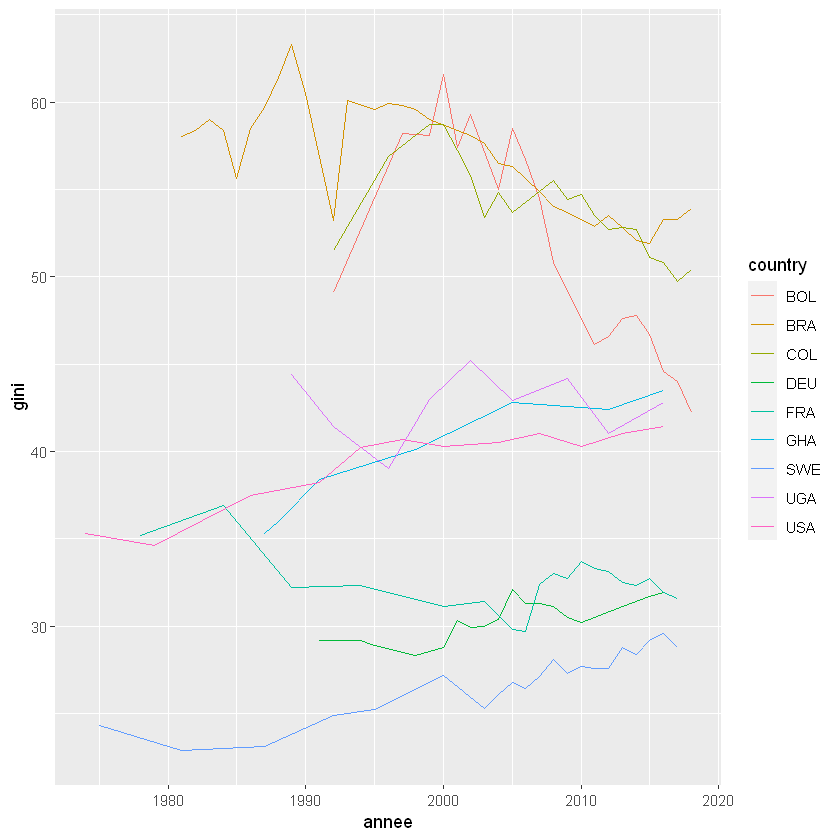

In [10]:
###Je charge une table contenant les indices de gini de nombreux
###pays sur plusieurs années
gini<-read.csv("gini_index.csv", encoding = "UTF-8", skip = 4)%>%
      select(-"X")

###Je ne garde que depuis 1970 pas assez de données pour les dates
###précédentes
gini<-select(gini, c(2,15:64))

###Je réorganise le tableau et je le mets en forme
gini<-melt(data = gini, id.vars = 1, 
                 measure.vars = 2:51)

gini$variable<-gsub("^.","",gini$variable)


colnames(gini)<-c("country","annee","gini")

gini$annee<-gini$annee%>%as.numeric()

###je supprime les NAs pour que mon graphe relie tous les points
###même ceux séparer par plusieurs années
gini<-gini%>%na.omit()

###Je trace le graph des indices de gini de mes 10 pays par rapport 
###à l'année
ggplot(gini%>%filter(country %in%
  c("FRA","SWE","BRA","DEU","USA","GHA","COL","UGA","BOL")),
  aes(x = annee, y = gini ))+
  geom_line(aes(colour = country))

In [11]:
###Mission 3########################################################

###Je classe mes pays par région
amerique_latine<-read.csv("amerique_latine.csv",
              encoding = "UTF-8")%>%
  select("country_full" = "Zone")

amerique_latine$region<-"amerique_latine"

europe<-read.csv("europe.csv",
              encoding = "UTF-8")%>%
  select("country_full" = "Zone")

europe$region<-"europe"

asie<-read.csv("asie.csv",
              encoding = "UTF-8")%>%
  select("country_full" = "Zone")

asie$region<-"asie"

afrique<-read.csv("afrique.csv",
              encoding = "UTF-8")%>%
  select("country_full" = "Zone")

afrique$region<-"afrique"

fao_region<-rbind(afrique,asie,europe,amerique_latine)


fao_region$country_full<-fao_region$country_full%>%as.vector()

fao_region$country_full[fao_region$country_full == 
                      "États-Unis d'Amérique" ]<-"États-Unis"

fao_region$country_full[fao_region$country_full == 
               "Bolivie (État plurinational de)"]<-"Bolivie"

fao_region$country_full[fao_region$country_full == "République centrafricaine"]<-
  "République Centrafricaine"

fao_region$country_full[fao_region$country_full == "Chine, continentale"]<-"Chine"

fao_region$country_full[fao_region$country_full == "Chine, Taiwan Province de"]<-
  "Taïwan"

fao_region$country_full[fao_region$country_full == "République démocratique du Congo"]<-
  "République Démocratique du Congo"

fao_region$country_full[fao_region$country_full == "Tchéquie"]<-"République Tchèque"

fao_region$country_full[fao_region$country_full == "République dominicaine"]<-
  "République Dominicaine"

fao_region$country_full[fao_region$country_full == "Iran (République islamique d')"]<-
  "République Islamique d'Iran"

fao_region$country_full[fao_region$country_full == "République démocratique populaire lao"]<-
  "République Démocratique Populaire Lao"

fao_region$country_full[fao_region$country_full == "Soudan (ex)"]<-"Soudan"

fao_region$country_full[fao_region$country_full == "Eswatini"]<-"Swaziland"

fao_region$country_full[fao_region$country_full == "République arabe syrienne"]<-
  "République Arabe Syrienne"

fao_region$country_full[fao_region$country_full == 
  "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]<-
  "Royaume-Uni"

fao_region$country_full[fao_region$country_full == 
               "Venezuela (République bolivarienne du)"]<-"Venezuela"


dfs<-inner_join(df,fao_region)

df<-dfs

df$region[df$country %in% c("FIN","SWE","NOR","ISL","DNK")]<-
  "europe_nord"

df$region[df$country %in% c("USA","CAN")]<-"amerique_nord"
       
head(df)

Joining, by = "country_full"


country,country_full,year_survey,quantile,nb_quantiles,income,gdpppp,pop,gini,region
ALB,Albanie,2008,1,100,728.8980,7297,3002.678,30.5,europe
ALB,Albanie,2008,2,100,916.6623,7297,3002.678,30.5,europe
ALB,Albanie,2008,3,100,1010.9160,7297,3002.678,30.5,europe
ALB,Albanie,2008,4,100,1086.9078,7297,3002.678,30.5,europe
ALB,Albanie,2008,5,100,1132.6997,7297,3002.678,30.5,europe
ALB,Albanie,2008,6,100,1171.1412,7297,3002.678,30.5,europe


[1] 11100

In [12]:
###J'attribut à chaque pays uun coef d'élasticité celon sa région
df$elasticite[df$region %in% c("afrique","amerique_latine")] <- 0.66
df$elasticite[df$region == "europe" | df$country == "USA"] <- 0.4
df$elasticite[df$region %in% c("asie")] <- 0.5
df$elasticite[df$region %in% c("europe_nord")| df$country == "CAN"] <- 0.2

head(df)

country,country_full,year_survey,quantile,nb_quantiles,income,gdpppp,pop,gini,region,elasticite
ALB,Albanie,2008,1,100,728.8980,7297,3002.678,30.5,europe,0.4
ALB,Albanie,2008,2,100,916.6623,7297,3002.678,30.5,europe,0.4
ALB,Albanie,2008,3,100,1010.9160,7297,3002.678,30.5,europe,0.4
ALB,Albanie,2008,4,100,1086.9078,7297,3002.678,30.5,europe,0.4
ALB,Albanie,2008,5,100,1132.6997,7297,3002.678,30.5,europe,0.4
ALB,Albanie,2008,6,100,1171.1412,7297,3002.678,30.5,europe,0.4


[1] 11100

In [13]:
###Je crée une fonction qui me permet de créer les tables de proba
###conditionnelles celon le coef, le nbre de quantile et le nombre
###d'individu par quantile
f_proba<-function(rho_j, nb_quantile, ind_quantile){

set.seed(100)
  
n<-nb_quantile*ind_quantile
ln_y_parent<-rnorm(n,0,1)
epsilon<-rnorm(n,0,1)
alpha<-0


y_child<-exp(alpha + rho_j*ln_y_parent + epsilon)
y_parent<-exp(ln_y_parent)


table<-data.frame(y_child,y_parent)
table$num<-row.names(table)

x<-arrange(table, y_child)
x$quantile<-trunc((row.names(x)%>%as.numeric()-1)/(n/nb_quantile))+1

y<-arrange(table, y_parent)
y$quantile<-trunc((row.names(x)%>%as.numeric()-1)/(n/nb_quantile))+1

table<-inner_join(x,y, by = c("num","y_child","y_parent"))%>%
  select("c_i_child" = "quantile.x", "c_i_parent" = "quantile.y")
  
table<-table%>%group_by(c_i_child,c_i_parent)%>%count()

x<-data.frame(c_i_child = factor(1:nb_quantile),
              c_i_parent = factor(1:nb_quantile))

y<-expand(x, c_i_child, c_i_parent)

table$c_i_child<- table$c_i_child%>%as.factor()
table$c_i_parent<- table$c_i_parent%>%as.factor()

table<-full_join(table,y)

table$n[is.na(table$n)]<-0 
table$proba_cond<-table$n/(n/nb_quantile)

table
}

a<-f_proba(0.9, 100, 1000)
head(a)

Joining, by = c("c_i_child", "c_i_parent")


c_i_child,c_i_parent,n,proba_cond
1,1,253,0.253
1,2,139,0.139
1,3,92,0.092
1,4,63,0.063
1,5,54,0.054
1,6,46,0.046


Joining, by = c("c_i_child", "c_i_parent")
Joining, by = c("c_i_child", "c_i_parent")


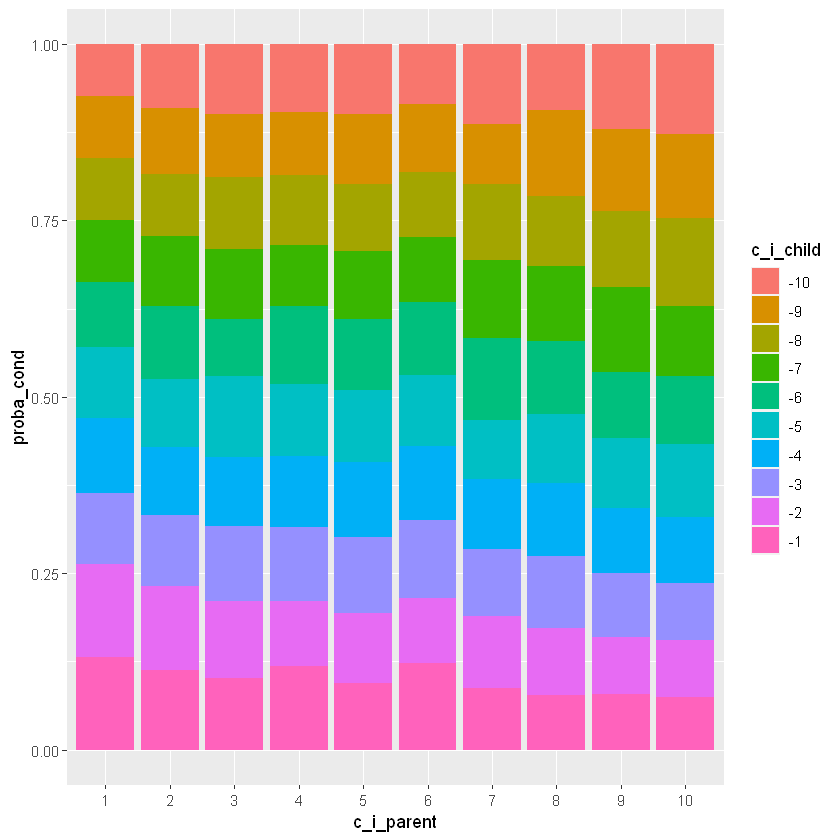

In [14]:
###Je crée deux tables et je dessine les histogrammes associés
table_proba_cond0.1<-f_proba(0.1, 10, 1000)
table_proba_cond0.9<-f_proba(0.9, 10, 1000)


ggplot(table_proba_cond0.1,
       aes(c_i_parent, proba_cond, fill = desc(c_i_child)%>%as.factor()))+
  geom_bar(stat = "identity") + labs( fill = "c_i_child")

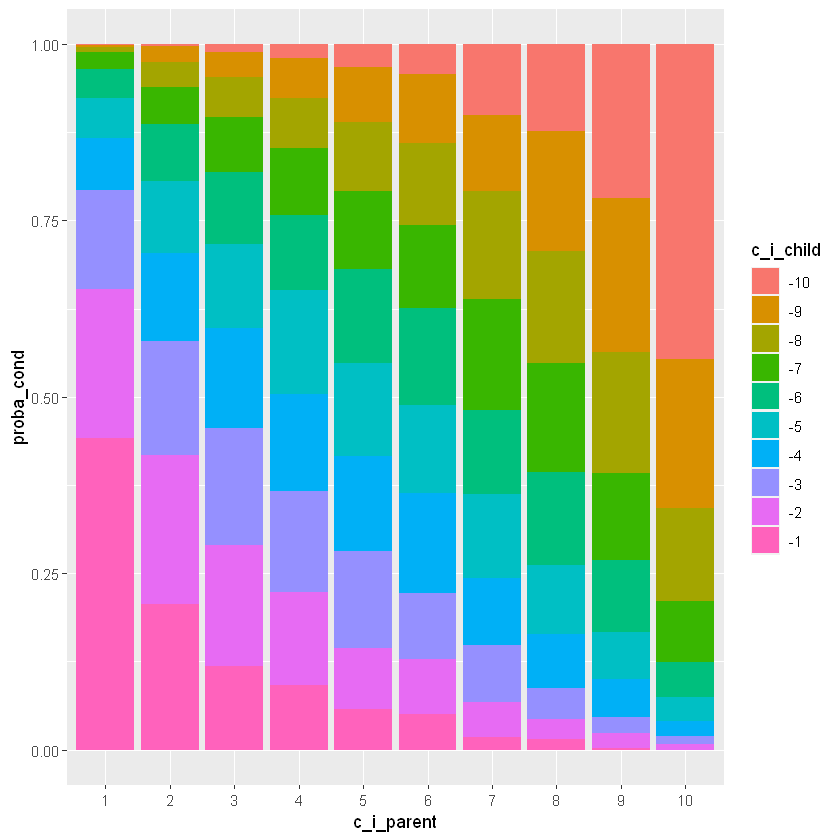

In [15]:
ggplot(table_proba_cond0.9,
       aes(c_i_parent, proba_cond, fill = desc(c_i_child)%>%as.factor()))+
  geom_bar(stat = "identity") + labs( fill = "c_i_child")

In [16]:
###Mission 4#########################################################

###Je crée une fonction qui me permet d'ajouter la colonne c_i_parent
###dans ma table principale.
###La fonction crée la classe de revenu de 50000 parents 500 pour chaque
###quantile celon un coef d'élasticité donné 
f<-function(rho_j){

    
nb_quantile<-100
n<-nb_quantile*500
ln_y_parent<-rnorm(n,0,1)
epsilon<-rnorm(n,0,1)
alpha<-0


y_child<-exp(alpha + rho_j*ln_y_parent + epsilon)
y_parent<-exp(ln_y_parent)


table<-data.frame(y_child,y_parent)
table$num<-row.names(table)

x<-arrange(table, y_child)
x$quantile<-trunc((row.names(x)%>%as.numeric()-1)/(n/nb_quantile))+1

y<-arrange(table, y_parent)
y$quantile<-trunc((row.names(x)%>%as.numeric()-1)/(n/nb_quantile))+1

table<-inner_join(x,y, by = c("num","y_child","y_parent"))%>%
  select("c_i_child" = "quantile.x", "c_i_parent" = "quantile.y")

table$c_i_parent
}

###Je crée une fonction pour pouvoir répéter la fonction précédente
###de façon aléatoire un nombre de fois donné pour un coef donné
rep_f<-function(x, n){
b<-c()
for (i in 1:n) {

  b<-c(b,f(x))
}
b    
}

In [17]:
###Je clone 500 fois chaque individu
df500<-df[rep(1:nrow(df), each = 500),]%>%rename("c_i_child" ="quantile")

###Je compte combien de pays sont associés à chaque coef d'élasticité
n0.2<-df%>%filter(elasticite == 0.2)%>%nrow()/100
n0.4<-df%>%filter(elasticite == 0.4)%>%nrow()/100
n0.5<-df%>%filter(elasticite == 0.5)%>%nrow()/100
n0.66<-df%>%filter(elasticite == 0.66)%>%nrow()/100

###Je crée ma colonne c_i_parent pour mes 5550000 enfants en répétant
###la fonction f autant de fois qu'il y a de pays par coef
a1<-rep_f(0.2,n0.2)
a2<-rep_f(0.4,n0.4)
a3<-rep_f(0.5,n0.5)
a4<-rep_f(0.66,n0.66)

###Je crée la colonne en ordonnant du plus petit coef au plus grand
c_i_parent<-c(a1,a2,a3,a4)

###Je colle ma colonne en ordonnant ma table principale de la même façon
###pour que ça corresponde
df500<-cbind(df500%>%arrange(elasticite),c_i_parent)

head(df500)

,country,country_full,year_survey,c_i_child,nb_quantiles,income,gdpppp,pop,gini,region,elasticite,c_i_parent
1501,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,58
1501.1,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,5
1501.2,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,51
1501.3,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,1
1501.4,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,94
1501.5,CAN,Canada,2008,1,100,122.4248,35895,33337.64,35,amerique_nord,0.2,46


In [18]:
###Je crée une fonction qui fait les tests et graphs de regression linéaire
f_graph<- function(fit, p){

df_function<-fit$model  
alpha <- 0.05
n <- dim(df_function)[1]
analyses <- data.frame(obs= 1:n)
analyses$levier <- hat(model.matrix(fit))
seuil_levier <- 2*p/n

analyses$rstudent <- rstudent(fit)
seuil_rstudent <- qt(1-alpha/2,n-p-1)

influence <- influence.measures(fit)
names(influence)
colnames(influence$infmat)

analyses$dcook <- influence$infmat[,"cook.d"]
seuil_dcook <- 4/(n-p)

layout(matrix(1:4, 2, 2))


return(
  list(
   plot(fit),
    
    ggplot(data.frame(fit$residuals),aes(fit.residuals)) + 
 geom_histogram(aes(y=..count..), colour="blue", fill= "white")+
  geom_vline(aes(xintercept=mean(fit.residuals), color="red"))+
  xlab("Residuals values")+ ylab("Number of residuals"),
    
ggplot(data=analyses,aes(x=obs, y=levier))+
   geom_bar(stat="identity",colour="steelblue")+
   geom_hline(yintercept=seuil_levier,col="red")+
   theme_minimal()+
   xlab("Observation")+
   ylab("Leviers")+
   scale_x_continuous(breaks=seq(0,n,by=5)),

ggplot(data=analyses,aes(x=obs,y=rstudent))+
  geom_bar(stat="identity",colour="steelblue")+
  geom_hline(yintercept=-seuil_rstudent,col="red")+
  geom_hline(yintercept=seuil_rstudent,col="red")+
  theme_minimal()+
  xlab("observation")+
  ylab("Résidus studentisés")+
  scale_x_continuous(breaks=seq(0,n,by=5)),

summary(fit),

vif(fit),

shapiro.test(sample(fit$residuals,5000)),

ad.test(fit$residuals),

ks.test(fit$residuals, "pnorm")
)
)
}

hat values (leverages) are all = 0.01
 and there are no factor predictors; no plot no. 5


 lag Autocorrelation D-W Statistic p-value
   1       0.6717958     0.6555143       0
 Alternative hypothesis: rho != 0


	Shapiro-Wilk normality test

data:  sample(fit_aov$residuals, 5000)
W = 0.55339, p-value < 2.2e-16



	Anderson-Darling normality test

data:  fit_aov$residuals
A = 1140.4, p-value < 2.2e-16



	One-sample Kolmogorov-Smirnov test

data:  fit_aov$residuals
D = 0.65499, p-value < 2.2e-16
alternative hypothesis: two-sided



	Fligner-Killeen test of homogeneity of variances

data:  residuals(fit_aov) by df$country
Fligner-Killeen:med chi-squared = 5271.7, df = 110, p-value < 2.2e-16



	Bartlett test of homogeneity of variances

data:  residuals(fit_aov) by df$country
Bartlett's K-squared = 18474, df = 110, p-value < 2.2e-16



Call:
lm(formula = income ~ country, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-24840  -1907   -393    493 151425 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2994.83     685.65   4.368 1.27e-05 ***
countryARG   2853.05     969.66   2.942 0.003264 ** 
countryARM  -1366.45     969.66  -1.409 0.158804    
countryAUT  13642.77     969.66  14.070  < 2e-16 ***
countryAZE   -637.40     969.66  -0.657 0.510973    
countryBEL  12029.78     969.66  12.406  < 2e-16 ***
countryBFA  -2048.49     969.66  -2.113 0.034659 *  
countryBGD  -1996.14     969.66  -2.059 0.039557 *  
countryBGR   1990.15     969.66   2.052 0.040153 *  
countryBIH   3339.86     969.66   3.444 0.000575 ***
countryBLR    926.33     969.66   0.955 0.339438    
countryBOL     21.43     969.66   0.022 0.982365    
countryBRA   1812.65     969.66   1.869 0.061598 .  
countryBTN  -1478.90     969.66  -1.525 0.127244    
countryCAF  -2183.53     969.66  -2.252 0.024351 *  
coun

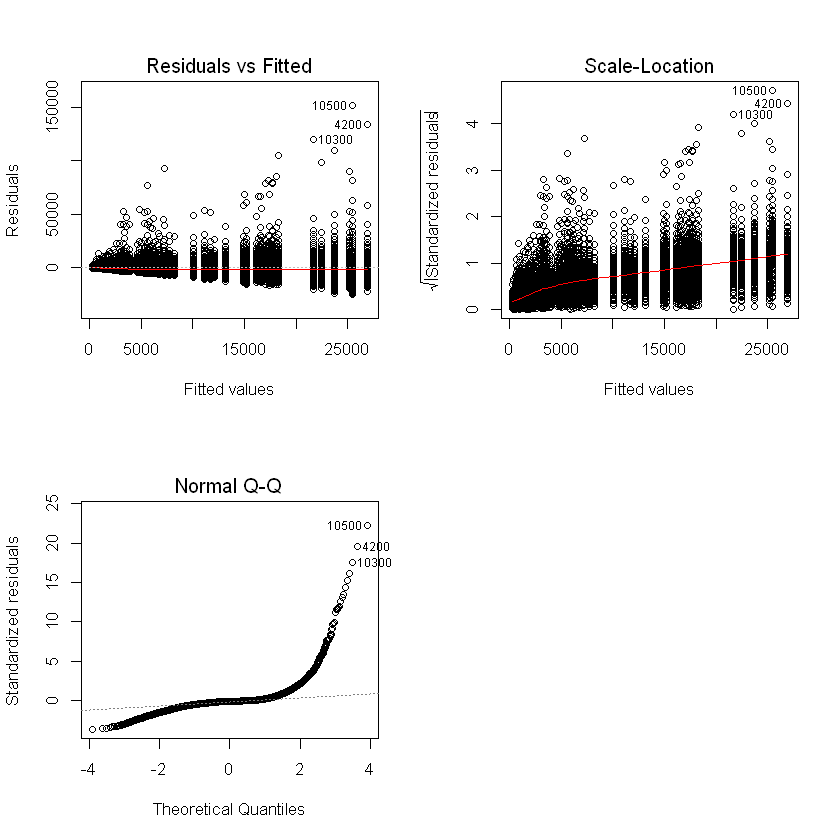

In [20]:
###Je fais des regressions linéaires pour expliquer au mieux
###la variable income.

###Anova income ~ country
fit_aov<-lm(income ~ country, df)

###Graphe analyse résidus
layout(matrix(1:4, 2, 2))
plot(fit_aov)

###test normalité résidu
shapiro.test(sample(fit_aov$residuals,5000))

ad.test(fit_aov$residuals)

ks.test(fit_aov$residuals, "pnorm")


###test homogénéité résidu
fligner.test(residuals(fit_aov)~df$country)

bartlett.test(residuals(fit_aov)~df$country)

###Analyse
summary(fit_aov)